In [1]:
import os
import pandas as pd
import collections
import pickle
#import cPickle
import _pickle as cPickle

import scipy
from scipy import sparse
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec, CoherenceModel
from gensim.summarization import summarize

from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics
import time

import bokeh

In [2]:
# Configurations and Variable Definitions

In [3]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
DATA_FILE = DATA_FILE = '/data/pubmedtext.txt'
#test variables
# test_pmid = '27179337'
test_pmid = '28324318'

In [4]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

In [5]:
# Input File Processing

In [6]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
#Note that this differs from above by removing grants and affiliations in an effort to minimize exceptions
def read_medline_data_raw(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "abstract"])
    count = 0
    for rec in recs:
        try:
            pmid = rec['PMID']
            atitle = rec["TI"]
            jtitle = rec["JT"]
            pubdate = rec["DP"]
            abstr = rec["AB"]
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle,pubdate, abstr]],
                columns=["pmid", "articletitle", "journaltitle", "pubdate", "abstract"]),ignore_index=True, verify_integrity=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [7]:
# get the Data file path

print("Cell started at: " + time.strftime("%c"))
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data_raw(DATA_PATH)
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')
papers.to_csv('data/papers_pain_EngFilter_6_5_2017_raw_oct17update.csv')
print("Cell completed at: " + time.strftime("%c"))

Cell started at: Fri May 18 08:15:37 2018
CPU times: user 133 ms, sys: 53 µs, total: 133 ms
Wall time: 390 ms
Cell completed at: Fri May 18 08:15:37 2018


In [8]:
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')

In [9]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
abstract        61 non-null object
articletitle    61 non-null object
journaltitle    61 non-null object
pmid            61 non-null object
pubdate         61 non-null object
dtypes: object(5)
memory usage: 2.5+ KB


In [10]:
pubdatevalues = papers.pubdate.unique()
#pubdatevalues.tofile("pubdatevalues.csv", sep=',') Examine range of pubdates manually in csv

In [11]:
papers['pubdate_dtformat'] = pd.to_datetime(papers.pubdate, format='%Y', exact=False)
papers['pubyear'] = pd.DatetimeIndex(papers['pubdate_dtformat']).year
papers=papers.drop('pubdate_dtformat', axis=1)

In [12]:
papers.tail(10)

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear
51,Non-steroidal anti-inflammatory drugs (NSAIDs)...,Anti-inflammatory and antinociceptive activiti...,International immunopharmacology,21855654,2011 Nov,2011
52,We investigated the changes in characteristics...,Expression of inflammatory and apoptosis facto...,International immunopharmacology,21821152,2011 Nov,2011
53,"INTRODUCTION: Flupirtine, a nonopioid analgesi...",Efficacy and tolerability of flupirtine in sub...,International journal of clinical pharmacology...,22011688,2011 Nov,2011
54,Post-herpetic neuralgia means pain which occur...,Modified Jaipur block for the treatment of pos...,International journal of dermatology,22004501,2011 Nov,2011
55,Antipsychotic drugs are the clinical standard ...,Dynamic regulation of dopamine and serotonin r...,The international journal of neuropsychopharma...,21281560,2011 Nov,2011
56,"BACKGROUND: Sex, race, and age disparities in ...",Patient demographic characteristics and facial...,International journal of nursing studies,21596378,2011 Nov,2011
57,BACKGROUND: Even though the use of a 25 gauge ...,Comparison of post-dural puncture headache and...,International journal of nursing studies,21561619,2011 Nov,2011
58,PURPOSE: We analyzed variables associated with...,Predictors of long-term toxicity using three-d...,"International journal of radiation oncology, b...",20933342,2011 Nov 01,2011
59,PURPOSE: To correlate computed tomography (CT)...,Correlation of computed tomography imaging fea...,"International journal of radiation oncology, b...",20889265,2011 Nov 01,2011
60,Rheumatoid arthritis (RA) is one of the inflam...,The antinociceptive efficacy of HWTX-I epidura...,International journal of sports medicine,22052031,2011 Nov,2011


In [13]:
papers.loc[papers['pubdate']=='2011 Nov']

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear
0,OBJECTIVE: To define the value of multislice c...,Value of multislice computed tomography in the...,European journal of radiology,20719444,2011 Nov,2011
1,OBJECTIVES: To assess the feasibility of T2 ma...,Quantitative in vivo MRI evaluation of lumbar ...,European radiology,21748388,2011 Nov,2011
2,Intraosseous lipoma is an uncommon mesenchymal...,Intraosseous lipoma presenting as a sphenoid s...,European review for medical and pharmacologica...,22195370,2011 Nov,2011
3,OBJECTIVE: Aim of the present work is to asses...,Combined occlusal and pharmacological therapy ...,European review for medical and pharmacologica...,22195362,2011 Nov,2011
4,PURPOSE: There are few prospective studies on ...,"Surgery improves pain, function and quality of...",European spine journal : official publication ...,21706361,2011 Nov,2011
5,INTRODUCTION: Chronic pain has an impact on ps...,The effect of repeated restraint stress in pai...,European spine journal : official publication ...,21698480,2011 Nov,2011
6,PURPOSE: TNFalpha is an inflammatory mediator ...,Etanercept attenuates pain-related behavior fo...,European spine journal : official publication ...,21633793,2011 Nov,2011
7,It is becoming increasingly evident that peopl...,Effects of experimentally induced low back pai...,Experimental brain research,21952791,2011 Nov,2011
8,"AIMS: Gastrointestinal symptoms such as pain, ...",Effects of isolated hyperinsulinaemia on senso...,Experimental and clinical endocrinology & diab...,22068552,2011 Nov,2011
9,BACKGROUND: The clinical picture of pituitary ...,Hypopituitarism in a HIV affected patient.,Experimental and clinical endocrinology & diab...,21922454,2011 Nov,2011


In [14]:
papers.journaltitle.nunique()

39

In [15]:
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')

In [16]:
# Text Cleanup & Tokenization

In [17]:
## Remove "all-caps:" section headers, punctuation marks, numbers, and option for words in all capital letters

In [53]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    
    return abstracts, non_digit_filtered

In [54]:
## Remove stop words

In [55]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = str.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

In [56]:
## Convert to lower case, tokenize

In [57]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [58]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

In [59]:
## Combine Preprocess Functions

In [60]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [62]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    return abstracts

In [63]:
## Apply preprocessing

In [64]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
%time papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

CPU times: user 3.97 ms, sys: 0 ns, total: 3.97 ms
Wall time: 3.97 ms


In [65]:
#Show list of filtered terms
print(filtered)

['', 'CONCLUSIONS', 'INTRODUCTION', ' METHODS AND', ' DESIGN AND', ' PATIENTS AND', 'PURPOSE', 'REPORT', ' CASE', ' RESULTS AND', ' ', ' MATERIALS AND', 'BACKGROUND', 'SETTINGS', 'METHODS', 'OBJECTIVES', 'DESIGN', 'BACKGROUND AND', 'OBJECTIVE', 'AIM', 'METHOD', 'OPINION', 'MATERIALS', 'AIMS', ' AREAS', ' AND', 'CONCLUSION', ' EXPERT', 'PARTICIPANTS', 'UNLABELLED', 'COVERED', 'PATIENTS', 'LIMITATIONS', 'RESULTS', "that'll", 'yourself', 'these', 'them', 'being', 'once', "mustn't", "haven't", 'mightn', 'there', 'not', 'its', "wouldn't", 'needn', 'other', "didn't", 'so', 'haven', 'through', "should've", 'those', "shouldn't", "weren't", 'ma', "doesn't", 'and', "you'll", 'for', 've', 'under', 'himself', 'i', 'about', 'down', 'itself', 'we', 'of', 'is', 'which', 'from', 't', 'her', 'only', 'wouldn', 'shan', 'until', 'ourselves', 'am', 'then', 'aren', 'him', 'own', 'during', 'as', 'yourselves', 'does', 'against', "don't", 'more', 'doing', 'were', 'didn', 'here', "needn't", "shan't", 'into', 'c

In [66]:
papers.to_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')
%time papers = pd.read_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')

CPU times: user 4.3 ms, sys: 19 µs, total: 4.32 ms
Wall time: 4.33 ms


In [67]:
papers

,abstract,articletitle,journaltitle,pmid,pubdate,pubyear,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract
0,OBJECTIVE: To define the value of multislice c...,Value of multislice computed tomography in the...,European journal of radiology,20719444,2011 Nov,2011,define value multislice computed tomography ct...,"[define, value, multislice, computed, tomograp...",OBJECTIVE#NUM To define the value of multislic...,"[OBJECTIVE, To, define, the, value, of, multis...",131,238,84
1,OBJECTIVES: To assess the feasibility of T2 ma...,Quantitative in vivo MRI evaluation of lumbar ...,European radiology,21748388,2011 Nov,2011,assess feasibility mapping lumbar facet joints...,"[assess, feasibility, mapping, lumbar, facet, ...",OBJECTIVES#NUM To assess the feasibility of T#...,"[OBJECTIVES, To, assess, the, feasibility, of,...",117,203,72
2,Intraosseous lipoma is an uncommon mesenchymal...,Intraosseous lipoma presenting as a sphenoid s...,European review for medical and pharmacologica...,22195370,2011 Nov,2011,intraosseous lipoma uncommon mesenchymal tumor...,"[intraosseous, lipoma, uncommon, mesenchymal, ...",Intraosseous lipoma is an uncommon mesenchymal...,"[Intraosseous, lipoma, is, an, uncommon, mesen...",78,140,64
3,OBJECTIVE: Aim of the present work is to asses...,Combined occlusal and pharmacological therapy ...,European review for medical and pharmacologica...,22195362,2011 Nov,2011,aim present work assess effectiveness scientif...,"[aim, present, work, assess, effectiveness, sc...",OBJECTIVE#NUM Aim of the present work is to as...,"[OBJECTIVE, Aim, of, the, present, work, is, t...",88,163,62
4,PURPOSE: There are few prospective studies on ...,"Surgery improves pain, function and quality of...",European spine journal : official publication ...,21706361,2011 Nov,2011,prospective studies surgical outcomes survival...,"[prospective, studies, surgical, outcomes, sur...",PURPOSE#NUM There are few prospective studies ...,"[PURPOSE, There, are, few, prospective, studie...",165,284,115
5,INTRODUCTION: Chronic pain has an impact on ps...,The effect of repeated restraint stress in pai...,European spine journal : official publication ...,21698480,2011 Nov,2011,chronic pain impact psychological social facto...,"[chronic, pain, impact, psychological, social,...",INTRODUCTION#NUM Chronic pain has an impact on...,"[INTRODUCTION, Chronic, pain, has, an, impact,...",190,321,99
6,PURPOSE: TNFalpha is an inflammatory mediator ...,Etanercept attenuates pain-related behavior fo...,European spine journal : official publication ...,21633793,2011 Nov,2011,tnfalpha inflammatory mediator related neuropa...,"[tnfalpha, inflammatory, mediator, related, ne...",PURPOSE#NUM TNFalpha is an inflammatory mediat...,"[PURPOSE, TNFalpha, is, an, inflammatory, medi...",153,272,98
7,It is becoming increasingly evident that peopl...,Effects of experimentally induced low back pai...,Experimental brain research,21952791,2011 Nov,2011,becoming increasingly evident people chronic r...,"[becoming, increasingly, evident, people, chro...",It is becoming increasingly evident that peopl...,"[It, is, becoming, increasingly, evident, that...",166,256,102
8,"AIMS: Gastrointestinal symptoms such as pain, ...",Effects of isolated hyperinsulinaemia on senso...,Experimental and clinical endocrinology & diab...,22068552,2011 Nov,2011,gastrointestinal symptoms pain bloating nausea...,"[gastrointestinal, symptoms, pain, bloating, n...",AIMS#NUM Gastrointestinal symptoms such as pai...,"[AIMS, Gastrointestinal, symptoms, such, as, p...",134,229,92
9,BACKGROUND: The clinical picture of pituitary ...,Hypopituitarism in a HIV affected patient.,Experimental and clinical endocrinology & diab...,21922454,2011 Nov,2011,clinical picture pituitary abscesses may resem...,"[clinical, picture, pituitary, abscesses, may,...",BACKGROUND#NUM The clinical picture of pituita...,"[BACKGROUND, The, clinic

In [68]:
#Test
print('Original Abstract: \n', papers.abstract[papers.pmid == test_pmid])
print('\nCleaned Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL])
print('\nTokenized Abstract: \n', papers.loc[papers.pmid == test_pmid, TOKENIZED_CLEAN_ABS_COL])
print('\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL])
papers[(papers.pmid == test_pmid)]

Original Abstract: 
 Series([], Name: abstract, dtype: object)

Cleaned Abstract: 
 Series([], Name: cleaned_abstract, dtype: object)

Tokenized Abstract: 
 Series([], Name: tokenized_c_abstract, dtype: object)

Minimally Processed Abstract: 
 Series([], Name: cleaned_minimal_abstract, dtype: object)


,abstract,articletitle,journaltitle,pmid,pubdate,pubyear,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract


In [69]:
# Topic Modeling with LDA

In [70]:
## Create Corpus, Dictionary, and Related Text Constructs

In [71]:
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [72]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [73]:
## Topic Modeling via LDA

In [74]:
### Determine optimal number of topics through coherence testing

In [75]:
def LDA_compute_coherence_values(dictionary, corpus, texts, limit):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(2, limit, 6):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, 
                                                 workers=16)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
LDA_model_list, LDA_coherence_values = LDA_compute_coherence_values(dictionary=ca_gs_dictionary, corpus=ca_gs_corpus, texts=abstract_list, limit=50)

In [77]:
print(LDA_model_list)
print(LDA_coherence_values)

[<gensim.models.ldamulticore.LdaMulticore object at 0x7f5e70c99b38>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e70cb6fd0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e78accfd0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e70c94048>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e70f0ec88>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e7069be48>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e78ce4da0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7f5e78cc17b8>]
[0.28128320021148323, 0.36405741995554575, 0.3305296463363217, 0.45759374231156447, 0.46877384368989533, 0.54393323553271689, 0.5205057786560161, 0.52470548680985585]


In [78]:
with open('LDA_model_list.pkl', 'wb') as f:
    pickle.dump(LDA_model_list, f)
    
with open('LDA_coherence_values.pkl', 'wb') as f:
    pickle.dump(LDA_coherence_values, f)

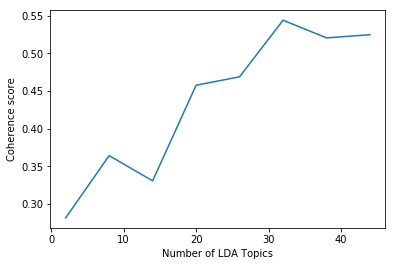

In [79]:
limit=50
x = range(2, limit, 6)
plt.plot(x, LDA_coherence_values)
plt.xlabel("Number of LDA Topics")
plt.ylabel("Coherence score")
# plt.legend(("LDA_coherence_values"), loc='best')
plt.show()

In [40]:
for m, cv in zip(x, LDA_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2908
Num Topics = 8  has Coherence Value of 0.3641
Num Topics = 14  has Coherence Value of 0.4298
Num Topics = 20  has Coherence Value of 0.4331
Num Topics = 26  has Coherence Value of 0.4467
Num Topics = 32  has Coherence Value of 0.4969
Num Topics = 38  has Coherence Value of 0.5096
Num Topics = 44  has Coherence Value of 0.5624


In [41]:
num_of_LDA_topics = 25 #Derived from coherence testing of topic counts from 2 to 50 for LDA

In [42]:
### Run LDA with 25 topics

In [43]:
# %time lda = models.LdaModel(ca_gs_corpus, num_topics=num_of_LDA_topics, id2word =ca_gs_dictionary, update_every=5, passes=100)
%time lda_mc = models.ldamulticore.LdaMulticore(corpus=ca_gs_corpus, num_topics=num_of_LDA_topics, id2word=ca_gs_dictionary, passes=100, workers=16)

CPU times: user 13.1 s, sys: 1.57 s, total: 14.7 s
Wall time: 12.7 s


In [ ]:
## Doc-Topic distribution

In [45]:
# Get document topics
all_topics = lda_mc.get_document_topics(ca_gs_corpus, minimum_probability=0)
all_topics[0]

[(0, 0.00030534333),
 (1, 0.00030534333),
 (2, 0.00030534333),
 (3, 0.008711149),
 (4, 0.00030534333),
 (5, 0.00030534333),
 (6, 0.98426598),
 (7, 0.00030534333),
 (8, 0.00030534333),
 (9, 0.00030534333),
 (10, 0.00030534333),
 (11, 0.00030534333),
 (12, 0.00030534333),
 (13, 0.00030534333),
 (14, 0.00030534333),
 (15, 0.00030534333),
 (16, 0.00030534333),
 (17, 0.00030534333),
 (18, 0.00030534333),
 (19, 0.00030534333),
 (20, 0.00030534333),
 (21, 0.00030534333),
 (22, 0.00030534333),
 (23, 0.00030534333),
 (24, 0.00030534333)]

In [ ]:
## Prepare the Input files for Tensorboard

In [47]:
import gensim
import pandas as pd
import smart_open
import random
from smart_open import smart_open

In [50]:
# create file for tensors
with smart_open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
with smart_open('doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j, k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (j, k))

In [51]:
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

# overwrite metadata file
i=0
with smart_open('doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j,k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

In [ ]:
# we upload the previous tensor file "doc_lda_tensor.tsv" and this new metadata file to http://projector.tensorflow.org/ . 

In [ ]:
#Visualize using T-SNE [ Just change the tab in left ]

In [ ]:
model.show_topic(topicid=0, topn=15)